# **BERTopic on Large Datasets**

Due to the modularity of BERTopic, it can also be used on large datasets (> 1_000_000) if we change some of the internal algorithms such that they can scale a bit better.

To do so, this example uses Google Colab Pro (T4 with 25GB of VRAM and 26GB of System RAM) and cuML to enable GPU-accelerated machine learning.

First, we will need to install some packages:

In [3]:
%%capture
!pip install git+https://github.com/MaartenGr/BERTopic.git@master

!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

!pip install safetensors
!pip install datasets
!pip install datashader
!pip install adjustText
!pip install chardet

Sometimes, it might happen that you get the `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968` error, if so make sure to run the following code:

```python
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

**(Optional)** We can mount a personal Google Drive such that we can save the resulting embeddings and models that you create. Although it is not necessary, if you created embeddings and then run into memory errors, it is generally nice to have the embeddings saved somewhere without needing to recalculate them.

# **Data**

To show how BERTopic can be used with large data, we are going to load in some Wikipedia texts. Cohere has fortunately created a dataset split by paragraphs, which allows us to stay within token limit sizes.

For this example, we load in 1 million texts from Wikipedia and see if we can extract topics from them.

In [25]:
import pandas as pd
import os
import chardet

def get_encoding(file):
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

# Get current dir
current_dir = os.getcwd()

data_dir = os.path.join(current_dir, "data")
output_dir = os.path.join(current_dir, "output/twitter")
model_dir = os.path.join(current_dir, "model")
filepath = "twitter_ubisoft_combined.csv"
target_column = "rawContent"
title="twitter_ubisoft"


lang = 'en'


In [6]:
fp = os.path.join(data_dir, filepath)
df = pd.read_csv(fp,encoding=get_encoding(fp))
df = df[df["lang"]==lang]

docs = df[target_column].tolist()

# **Basic Example**

Now that we have our data, we can start with a basic example. This example shows the minimum steps necessary for training a BERTopic model on large datasets. Do note though that memory errors are still possible when tweaking parameters. After this section, some tips and tricks will be mentioned to demonstrate how we can further reduce memory or be more efficient with our training process.

## Embeddings

Next, we are going to pre-calculate the embeddings as input for our BERTopic model. The reason for doing this is that this input step can take quite some time to compute. If we pre-calculate them and save the resulting embeddings, we can skip over this step when we are iterating over our model.

In [2]:
from sentence_transformers import SentenceTransformer

# Create embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(docs, show_progress_bar=True)

/home/samuel/miniconda3/envs/is434/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Batches: 100%|██████████| 5207/5207 [00:56<00:00, 91.95it/s] 


We can save the resulting embeddings as follows:

In [3]:
import numpy as np
with open(f'./output/{title}_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

and then load the embeddings as follows:

In [4]:
import numpy as np
embeddings = np.load(f'./output/{title}_embeddings.npy')

## Prepare Vocab

Before we can start with training our model, there is still something that we can do to reduce the necessary memory. We can prepare our vocabulary beforehand such that the tokenizer does not need to do the calculations itself.

Below, we are essentially creating a vocabulary of words in our dataset and parsing them such that they need to appear at least 15 times in our data.

With sufficient RAM, we could skip over this step but I have found this often helps in reducing the necessary RAM.

**Note**: If you are using a custom CountVectorizer, then it is advised to use that instead of the default CountVectorizer to build the tokenizer.

In [7]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Extract vocab to be used in BERTopic
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))
vocab = [word for word, frequency in vocab.items() if frequency >= 15]; len(vocab)

100%|██████████| 166600/166600 [00:00<00:00, 191283.34it/s]


11169

## Train BERTopic

Finally, we can train our BERTopic model. We select the same sentence-transformer model as we did before. Moreover, we select cuML's HDBSCAN and UMAP models. These are GPU-accelerated versions of HDBSCAN and UMAP and allow us to speed training on such a large dataset.

In [9]:
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=130, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True)
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings)

2024-11-10 12:05:57,958 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


[D] [12:05:58.249249] /__w/cuml/cuml/cpp/src/umap/runner.cuh:107 n_neighbors=50
[D] [12:05:58.269691] /__w/cuml/cuml/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [12:06:01.546992] /__w/cuml/cuml/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [12:06:01.598761] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [12:06:01.600379] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0684477, 0.157479, 0.15961, 0.12941, 0.0887957, 0.0365031, 0.0966234, 0.119049, 0.113114, 0.0925677, 0.0904752, 0.0977085, 0.024476, 0.138567, 0.13564, 0.156828, 0.0285617, 0.183788, 0.172692, 0.148052, 0.0153858, 0.175422, 0.0319499, 0.0698307, 0.141856 ]

[D] [12:06:01.600495] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.293313, 0.0244735, 0.0244735, 1.19209e-07, 0.0113472, 0.278771, 1.78814e-07, 4.17233e-07, 4.76837e-07, 5.96046e-08, 1.19209e-07, 1.78814e-07, 0.332299, 0.00517291, 0.00517291, 2.38419e-07, 0

2024-11-10 12:06:13,927 - BERTopic - Dimensionality - Completed ✓
2024-11-10 12:06:13,937 - BERTopic - Cluster - Start clustering the reduced embeddings


[D] [12:06:13.803321] /__w/cuml/cuml/cpp/src/umap/runner.cuh:400 Smoothing KNN distances
[D] [12:06:13.815975] /__w/cuml/cuml/cpp/src/umap/runner.cuh:432 Executing fuzzy simplicial set
[D] [12:06:13.823443] /__w/cuml/cuml/cpp/src/umap/runner.cuh:461 Performing L1 normalization
[D] [12:06:13.843481] /__w/cuml/cuml/cpp/src/umap/runner.cuh:497 n_epochs=30
[D] [12:06:13.859068] /__w/cuml/cuml/cpp/src/umap/runner.cuh:520 Computing # of epochs for training each sample
[D] [12:06:13.861371] /__w/cuml/cuml/cpp/src/umap/runner.cuh:527 Performing optimization


2024-11-10 12:06:50,021 - BERTopic - Cluster - Completed ✓
2024-11-10 12:06:50,044 - BERTopic - Representation - Fine-tuning topics using representation models.
/home/samuel/miniconda3/envs/is434/lib/python3.11/site-packages/bertopic/vectorizers/_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df) + 1)
2024-11-10 12:06:51,365 - BERTopic - Representation - Completed ✓


and that is it! We can inspect the topics as follows:

In [10]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,119603,-1_ubisoft_game_http_games,"[ubisoft, game, http, games, https, like, cree...","[@Ubisoft Has to be Boobisoft, @mattbattmatt @..."
1,0,2816,0_creed_assassin_assassins_brotherhood,"[creed, assassin, assassins, brotherhood, ezio...","[@Ubisoft Assassin's Creed, #MaSoir√©ePS4 Assa..."
2,1,2110,1_dogs_watch_watchdogs_watch_dogs,"[dogs, watch, watchdogs, watch_dogs, date, leg...","[@UbiReflections @Ubisoft Watch Dogs 2, @Ubiso..."
3,2,2014,2_rayman_rabbids_mario_legends,"[rayman, rabbids, mario, legends, raving, king...","[@Ubisoft New rayman please, @Ubisoft Rayman 3..."
4,3,1712,3_congrats_congratulations_ubisoft_malekawt,"[congrats, congratulations, ubisoft, malekawt,...","[@Ghalibo_ @Ubisoft Congrats, @beccamalecca_ @..."
...,...,...,...,...,...
114,113,35,113_pre_preorder_preordered_ordering,"[pre, preorder, preordered, ordering, ordered,...",[@Ubisoft In fact I'm probably going to pre or...
115,114,35,114_ac2_battle_want_web,"[ac2, battle, want, web, rt, minutes, ago, 10,...",[@Ubisoft I want #AC2 Battle of Forli - 1387mb...
116,115,35,115_pax_booth_prime_2010,"[pax, booth, prime, 2010, trip, communities, l...",[Come say hi to us and play @TheCrewGame at th...
117,116,33,116_steam_epic_store_exclusivity,"[steam, epic, store, exclusivity, choice, stor...",[@MittenMarauder @xDarksagex @Cherrylicious_B ...


Lastly, it would be advised to save the model as follows:

In [11]:
topic_model.save(
    path=os.path.join(model_dir,title),
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model="sentence-transformers/all-MiniLM-L6-v2"
)

# **Advanced Tips & Tricks**

There are a number of advanced tips and tricks that you can use to make it a bit easier and more flexible to train your model at large datasets.

## UMAP

Just like we pre-computed the embeddings, we can pre-reduce the dimensionality of the embeddings with cuML's UMAP and use those.

This saves quite a bit of time since we need to reduce embeddings everytime we run BERTopic.

**NOTE**: Saving those embeddings, as we did before, is generally advised.

In [12]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

[D] [12:06:51.990139] /__w/cuml/cuml/cpp/src/umap/runner.cuh:107 n_neighbors=15
[D] [12:06:51.991124] /__w/cuml/cuml/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [12:06:55.199378] /__w/cuml/cuml/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [12:06:55.201931] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [12:06:55.202516] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0909982, 0.22939, 0.233006, 0.194485, 0.120761, 0.0387422, 0.136238, 0.172195, 0.163321, 0.132832, 0.129431, 0.155073, 0.0243052, 0.20381, 0.198876, 0.232316, 0.0301037, 0.294445, 0.271914, 0.231689, 0.00926584, 0.284247, 0.0258493, 0.0782256, 0.207808 ]

[D] [12:06:55.202586] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.293313, 0.0244735, 0.0244735, 1.19209e-07, 0.0113472, 0.278771, 1.78814e-07, 4.17233e-07, 4.76837e-07, 5.96046e-08, 1.19209e-07, 1.78814e-07, 0.332299, 0.00517291, 0.00517291, 2.38419e-07, 0.1

Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [13]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings_2d = umap_model.fit_transform(embeddings)

[D] [12:06:57.832153] /__w/cuml/cuml/cpp/src/umap/runner.cuh:107 n_neighbors=15
[D] [12:06:57.833561] /__w/cuml/cuml/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [12:07:00.809122] /__w/cuml/cuml/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [12:07:00.812499] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [12:07:00.813125] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0909982, 0.22939, 0.233006, 0.194485, 0.120761, 0.0387422, 0.136238, 0.172195, 0.163321, 0.132832, 0.129431, 0.155073, 0.0243052, 0.20381, 0.198876, 0.232316, 0.0301037, 0.294445, 0.271914, 0.231689, 0.00926584, 0.284247, 0.0258493, 0.0782256, 0.207808 ]

[D] [12:07:00.813314] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.293313, 0.0244735, 0.0244735, 1.19209e-07, 0.0113472, 0.278771, 1.78814e-07, 4.17233e-07, 4.76837e-07, 5.96046e-08, 1.19209e-07, 1.78814e-07, 0.332299, 0.00517291, 0.00517291, 2.38419e-07, 0.1

## HDBSCAN

We can even pre-compute the clusters with HDBSCAN and feed them to BERTopic to perform [manual topic modeling](https://maartengr.github.io/BERTopic/getting_started/manual/manual.html). Manual topic modeling with BERTopic means that if we already have labels of topics, we can use those to label them using a variety of [representation models](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html).

BERTopic can still perform inference since inference is done on topic embeddings that are created during `fit`.

In [18]:
from cuml.cluster import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=130, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [19]:
from cuml.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster

import openai
from bertopic.representation import OpenAI
from dotenv import load_dotenv

load_dotenv()

OPEN_AI_KEY = os.environ.get("OPEN_AI_KEY")
client = openai.OpenAI(api_key=OPEN_AI_KEY)
representation_model = OpenAI(client, model="gpt-4o-mini", chat=True)

class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")


# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

2024-11-10 12:28:50,764 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-10 12:28:50,765 - BERTopic - Dimensionality - Completed ✓
2024-11-10 12:28:50,767 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-10 12:29:24,128 - BERTopic - Cluster - Completed ✓
2024-11-10 12:29:24,147 - BERTopic - Representation - Fine-tuning topics using representation models.
/home/samuel/miniconda3/envs/is434/lib/python3.11/site-packages/bertopic/vectorizers/_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df) + 1)
100%|██████████| 129/129 [01:08<00:00,  1.89it/s]
2024-11-10 12:30:34,709 - BERTopic - Representation - Completed ✓


In [26]:
topic_info = topic_model.get_topic_info()
topic_info.to_csv(f"{output_dir}/{title}_topic_info.csv", index=False)

## Visualize Documents

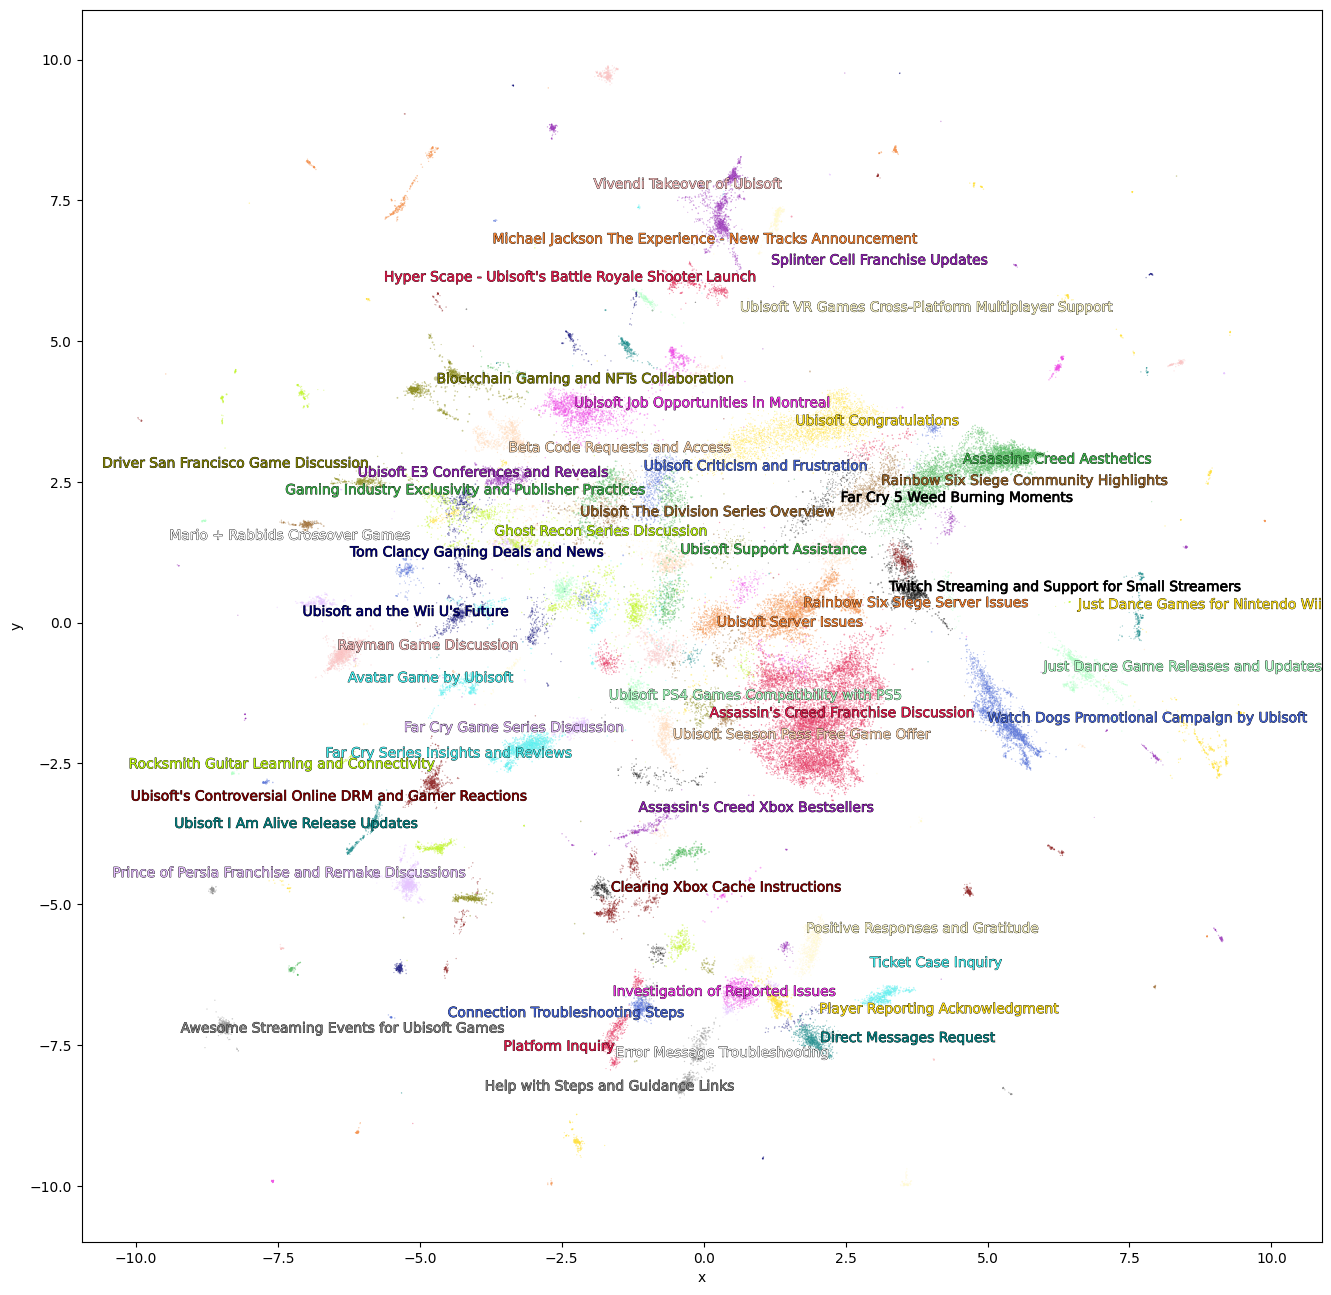

In [31]:
import itertools 
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

# Define colors for the visualization to iterate over
colors = itertools.cycle([
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
    '#000075', '#808080', '#ffffff', '#000000'
])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({
    "x": reduced_embeddings_2d[:, 0], 
    "y": reduced_embeddings_2d[:, 1], 
    "Topic": [str(t) for t in topic_model.topics_]
})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[
    (df.y > -10) & (df.y < 10) & 
    (df.x < 10) & (df.x > -10), :
]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

# Create scatter plot using hue and palette
fig = plt.figure(figsize=(16, 16))
sns.scatterplot(
    data=df, 
    x='x', 
    y='y', 
    hue='Topic', 
    palette=color_key, 
    alpha=0.4, 
    sizes=(0.4, 10), 
    size="Length",
    legend=False  # Optional: Disable legend if not needed
)

# Annotate top 50 topics
texts, xs, ys = [], [], []
for _, row in mean_df.iterrows():
    topic = row["Topic"]
    name = " - ".join([word for word, _ in topic_model.get_topic(int(topic))[:3]])
    
    if int(topic) <= 50:
        xs.append(row["x"])
        ys.append(row["y"])
        texts.append(
            plt.text(
                row["x"], row["y"], name, size=10, ha="center", 
                color=color_key[str(int(topic))],
                path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
            )
        )

# Adjust annotations to prevent overlap
adjust_text(
    texts, 
    x=xs, 
    y=ys, 
    time_lim=1, 
    force_text=(0.01, 0.02), 
    force_static=(0.01, 0.02), 
    force_pull=(0.5, 0.5)
)

plt.show()
# plt.savefig("visualization2.png", dpi=600)


In [33]:
plt.savefig(f"{output_dir}/{title}_visualization", dpi=600)

<Figure size 640x480 with 0 Axes>

In [28]:
df = topic_model.get_topic_info()
df.to_csv(f"{output_dir}/{title}_130_info.csv")

In [30]:
df = topic_model.get_document_info(docs)
df.to_csv(f"{output_dir}/{title}_130_document_info.csv")

In [34]:
fig = topic_model.visualize_topics()
fig.write_html(f"{output_dir}/{title}_130_visualization.html")